In [2]:
import matplotlib.pyplot as plt

# unused but required import for doing 3d projections with matplotlib < 3.2
import mpl_toolkits.mplot3d  # noqa: F401
from matplotlib import ticker

from sklearn import manifold

import numpy as np
from skimage.transform import resize
from skimage.morphology import area_closing

In [3]:
def image_resize(img, sz):
    return resize(img, sz)

def op_norm(arr:np.array):
    return (arr - arr.min()) / (arr.max() - arr.min())

# try to use closing technique for agg output to make it continuous first
def op_area_closing(arr, area_threshold, connectivity=1):
    arr_close = area_closing(arr, area_threshold, connectivity)
    return arr_close

def plot_3d(points, title):
    x, y, z = points.T

    fig, ax = plt.subplots(
        figsize=(6, 6),
        facecolor="white",
        tight_layout=True,
        subplot_kw={"projection": "3d"},
    )
    fig.suptitle(title, size=16)
    col = ax.scatter(x, y, z, c=z, s=50, alpha=0.8)
    # ax.view_init(azim=-60, elev=9)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.zaxis.set_major_locator(ticker.MultipleLocator(1))

    fig.colorbar(col, ax=ax, orientation="horizontal", shrink=0.6, aspect=60, pad=0.01)
    plt.show()


def plot_2d(points, title):
    fig, ax = plt.subplots(figsize=(3, 3), facecolor="white", constrained_layout=True)
    fig.suptitle(title, size=16)
    add_2d_scatter(ax, points, points[:,:,2])
    plt.show()


def add_2d_scatter(ax, points, points_color, title=None):
    x, y = points.T
    ax.scatter(x, y, c=points_color, s=50, alpha=0.8)
    ax.set_title(title)
    ax.xaxis.set_major_formatter(ticker.NullFormatter())
    ax.yaxis.set_major_formatter(ticker.NullFormatter())

def apply_colormap(z_vals, cmap_name='gray'):
    """
    Apply a colormap to a 2D numpy array and return the corresponding RGBA values.

    Parameters:
    - z_vals: 2D numpy array of scalar values.
    - cmap_name: String name of the colormap to use.

    Returns:
    - color_mapped: 3D numpy array with an RGBA color mapped from each z value.
    """
    # Normalize z_vals to the range [0, 1]
    norm = plt.Normalize(vmin=z_vals.min(), vmax=z_vals.max())
    
    # Get the colormap
    cmap = plt.cm.get_cmap(cmap_name)
    
    # Apply the colormap (including normalization)
    color_mapped = cmap(norm(z_vals))
    
    return color_mapped

def figure_show(fig, idx=None, vmin=None, vmax=None):
    if idx is None:
        plt.figure()
    else:
        plt.figure(idx)
    
    # If vmin and vmax are not provided, use the min and max values of the image.
    if vmin is None:
        vmin = fig.min()
    if vmax is None:
        vmax = fig.max()
    # Display the image with the specified vmin and vmax
    img = plt.imshow(fig, vmin=vmin, vmax=vmax)
    # Add a colorbar with the correct scaling.
    plt.colorbar(img)
    plt.show()

In [4]:
# normalize the distribution by mean and std
# do we have to exclude the val == 0 pixels?
def distribution_normalize(arr:np.array):
    mu = np.mean(arr)
    sigma = np.std(arr)
    return (arr - mu) / sigma

def distribution_minmax(arr:np.array):
    return (arr - arr.min()) / (arr.max() - arr.min())  

In [5]:
import ot
import cv2

def ot_transport_laplace(Xs, Xt):
    ot_emd_laplace = ot.da.EMDLaplaceTransport(reg_lap=100, reg_src=1, similarity='gauss')
    ot_emd_laplace.fit(Xs=Xs, Xt=Xt)

    transp_Xs_laplace = ot_emd_laplace.transform(Xs=Xs)
    return transp_Xs_laplace

def ot_transport_emd(Xs, Xt):
    ot_emd = ot.da.EMDTransport()
    ot_emd.fit(Xs=Xs, Xt=Xt)

    transp_Xs_emd = ot_emd.transform(Xs=Xs)
    return transp_Xs_emd

def ot_transport_mapping_linear(Xs, Xt, mu=1e0, eta=1e-8, bias=True, max_iter=20, verbose=True):
    ot_mapping_linear = ot.da.MappingTransport(
        kernel='linear',
        mu=mu,
        eta=eta,
        bias=bias,
        max_iter=max_iter,
        verbose=verbose
    )
    ot_mapping_linear.fit(Xs=Xs, Xt=Xt)

    transp_Xs_mapping_linear = ot_mapping_linear.transform(Xs=Xs)
    return transp_Xs_mapping_linear

def ot_transport_mapping_gaussian(Xs, Xt, eta=1e-5, mu=1e-1, bias=True, sigma=1,
    max_iter=10, verbose=True):
    ot_mapping_gaussian = ot.da.MappingTransport(
        kernel='gaussian',
        eta=eta,
        mu=mu,
        bias=bias,
        sigma=sigma,
        max_iter=max_iter,
        verbose=verbose
    )
    ot_mapping_gaussian.fit(Xs=Xs, Xt=Xt)

    transp_Xs_mapping_gaussian = ot_mapping_gaussian.transform(Xs=Xs)
    return transp_Xs_mapping_gaussian

def restore_from_normal(arr, mu, sigma):
    return arr * sigma + mu

def restore_from_minmax(arr, minval, maxval):
    return arr * (maxval - minval) + minval

def normal_dist_normalizer(arr):
    mu = np.mean(arr)
    sigma = np.std(arr)
    norm = distribution_normalize(arr)
    return norm, mu, sigma

def minmax_normalizer(arr):
    minv = np.min(arr)
    maxv = np.max(arr)
    norm = distribution_minmax(arr)
    return norm, minv, maxv

def build_pipeline(Xagg, Xdl, hollow_thr=10, method="minmax"):
    # now there are many hollow holes in agg result, do the closing operation
    # to remedy first
    # close_agg = op_area_closing(Xagg, 64, 1)
    close_agg = Xagg
    # find the invalid pixels, and apply on dl result
    insufficient_indices = np.where(Xagg <= hollow_thr)
    dl = np.copy(Xdl)
    dl[insufficient_indices] = 0
    trans_agg_restore = None
    # normalize the distribution for both agg and dl result
    # for the scale shift invariant
    if method == "normal":
        norm_agg, mu_agg, sigma_agg = normal_dist_normalizer(close_agg)
        norm_dl, mu_dl, sigma_dl = normal_dist_normalizer(dl)

        trans_agg = ot_transport_emd(norm_agg, norm_dl)
        trans_agg_restore = restore_from_normal(trans_agg, mu_agg, sigma_agg)
    elif method == "minmax":
        norm_agg, minv_agg, maxv_agg = minmax_normalizer(close_agg)
        norm_dl, minv_dl, maxv_dl = minmax_normalizer(dl)

        trans_agg = ot_transport_emd(norm_agg, norm_dl)
        trans_agg_restore = restore_from_minmax(trans_agg, minv_agg, maxv_agg)
    return trans_agg_restore

def build_guided_filter(Xs, Xt, radius=15, eps=0.1):
    assert Xs.shape == Xt.shape,"Images must have the same dimensions and channels"
    Xs = np.float32(Xs)
    Xt = np.float32(Xt)
    return cv2.ximgproc.guidedFilter(Xs, Xt, radius=radius, eps=eps)

def recheck(Xs:np.ndarray, Xt:np.ndarray, kernel_size=4, alpha=0.1, Ws=0.5, Wt=0.5):
    # make sure the width and height is divisible by kernel_size
    assert Xs.shape == Xt.shape,"Images must have the same dimensions and channels"
    assert Xs.shape[0] % kernel_size == 0, f"Image height {Xs.shape[0]} must be divisible by {kernel_size}."
    assert Xs.shape[1] % kernel_size == 0, f"Image width {Xs.shape[0]} must be divisible by {kernel_size}."
    
    Xsc = np.copy(Xs)

    for i in range(0, Xs.shape[0]-kernel_size, kernel_size):
        for j in range(0, Xs.shape[1]-kernel_size, kernel_size):
            # calculate the block mean and min max
            block_s = Xsc[i:i+kernel_size, j:j+kernel_size]
            block_t = Xt[i:i+kernel_size, j:j+kernel_size]
            mu_s = np.mean(block_s)
            mu_t = np.mean(block_t)
            minv_s = np.min(block_s)
            minv_t = np.min(block_t)
            maxv_s = np.max(block_s)
            maxv_t = np.max(block_t)

            cond = np.abs(mu_s-mu_t) <= alpha*mu_t and np.abs(minv_s-minv_t) <= alpha*minv_t and np.abs(maxv_s-maxv_t) <= alpha*maxv_t

            if not cond:
                Xsc[i:i+kernel_size, j:j+kernel_size] = Wt * block_t + Ws * block_s

    print("===> rechecking is completed!")
    return Xsc

def recheck_vectorized(Xs: np.ndarray, Xt: np.ndarray, kernel_size=4, alpha=0.1, Wt=0.5, Ws=0.5):
    # Ensure inputs meet assumptions
    assert Xs.shape == Xt.shape, "Images must have the same dimensions and channels"
    assert Xs.shape[0] % kernel_size == 0, f"Image height {Xs.shape[0]} must be divisible by {kernel_size}."
    assert Xs.shape[1] % kernel_size == 0, f"Image width {Xs.shape[1]} must be divisible by {kernel_size}."

    # Reshape images into (n_blocks_x, n_blocks_y, kernel_size, kernel_size, n_channels)
    # This groups each block's pixels together for block-wise operations
    K = kernel_size
    n_blocks_x, n_blocks_y = Xs.shape[0] // K, Xs.shape[1] // K
    Xs_blocks = Xs.reshape(n_blocks_x, K, n_blocks_y, K, -1).transpose(0, 2, 1, 3, 4)
    Xt_blocks = Xt.reshape(n_blocks_x, K, n_blocks_y, K, -1).transpose(0, 2, 1, 3, 4)

    # Compute mean, min, max for each block
    mu_s = Xs_blocks.mean(axis=(2, 3), keepdims=True)
    mu_t = Xt_blocks.mean(axis=(2, 3), keepdims=True)
    minv_s = Xs_blocks.min(axis=(2, 3), keepdims=True)
    minv_t = Xt_blocks.min(axis=(2, 3), keepdims=True)
    maxv_s = Xs_blocks.max(axis=(2, 3), keepdims=True)
    maxv_t = Xt_blocks.max(axis=(2, 3), keepdims=True)

    # Check conditions
    cond = (np.abs(mu_s - mu_t) <= alpha * mu_t) & \
           (np.abs(minv_s - minv_t) <= alpha * minv_t) & \
           (np.abs(maxv_s - maxv_t) <= alpha * maxv_t)

    # Apply updates
    updates = np.where(cond, Wt * Xt_blocks + Ws * Xs_blocks, Xs_blocks)

    # Reshape updates back to original image shape
    Xsc = updates.transpose(0, 2, 1, 3, 4).reshape(Xs.shape)
    
    print("===> rechecking is completed!")
    return Xsc

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm


class KLTripletOptimizer:

    def __init__(self, xs, xt, xd, device='cuda', reg_weight=1e-8):
        self.device = torch.device(device if torch.cuda.is_available() else 'cpu')
        print(f"Running on: {self.device}")
        self.kl_loss = nn.KLDivLoss(reduction='batchmean').to(self.device)
        self.huber_loss = nn.HuberLoss(reduction='mean').to(self.device)
        self.xs = xs.to(self.device).detach().requires_grad_(True)
        self.xs_init = self.xs.clone().detach()
        self.xt = xt.to(self.device)
        self.xd = xd.to(self.device)

        self.optimizer = optim.Adam([self.xs], lr=0.01)
        self.kl_losses = []
        self.huber_losses = []
        self.total_losses = []

        self.kl_w = 1.0
        self.hu_w = 1.0
        self.reg_weight = reg_weight

    def weights_adjust(self, kl_w, hu_w):
        self.kl_w = kl_w
        self.hu_w = hu_w

    def compute_histogram(self, x:torch.Tensor):
        # b, c, h, w = x.size()
        x = x.detach().squeeze().flatten()
        hist = torch.histc(x, bins=256)
        hist = hist / hist.sum()
        return hist
    
    def train(self, num_epoches=3000):
        for _ in tqdm(range(num_epoches)):
            self.optimizer.zero_grad()
            xs_norm = torch.sigmoid(self.xs)
            xd_norm = torch.sigmoid(self.xd)
            hist_s = self.compute_histogram(xs_norm)
            hist_d = self.compute_histogram(xd_norm)

            loss_kl = self.kl_loss(torch.log(hist_s+1e-10), hist_d)
            loss_huber = self.huber_loss(self.xs, self.xt)
            reg_loss = self.reg_weight * torch.norm(self.xs - self.xs_init)**2  # add a very small l2 to avoid overfitting
        
            self.kl_w = 1 / (1 + loss_huber.detach().item())
            self.hu_w = 1 / (1 + loss_kl.detach().item())
            total_loss = self.kl_w*loss_kl + self.hu_w*loss_huber + reg_loss

            total_loss.backward()
            self.optimizer.step()


            self.kl_losses.append(loss_kl.item())
            self.huber_losses.append(loss_huber.item())
            self.total_losses.append(total_loss.item())

In [90]:
# resize the source and target image for computation efficiency
full_agg = np.load('data/11/output_0222_agg.npy')
full_dl = np.load('data/11/output_0626_DLV2.npy')
scaled_agg = image_resize(full_agg, (full_agg.shape[0]//2, full_agg.shape[1]//2))
scaled_dl = image_resize(full_dl, (full_dl.shape[0]//2, full_dl.shape[1]//2))

# close_agg = op_area_closing(scaled_agg, 64, 1)
# close_agg = scaled_agg

# find the invalid pixels, and apply on dl result
insufficient_indices = np.where(scaled_agg <= 10)
dl = np.copy(scaled_dl)
dl[insufficient_indices] = 0

norm_agg, minv_agg, maxv_agg = minmax_normalizer(scaled_agg)
norm_dl, minv_dl, maxv_dl = minmax_normalizer(dl)
trans_agg = ot_transport_emd(norm_agg, norm_dl)
trans_agg_restore = restore_from_minmax(trans_agg, minv_agg, maxv_agg)

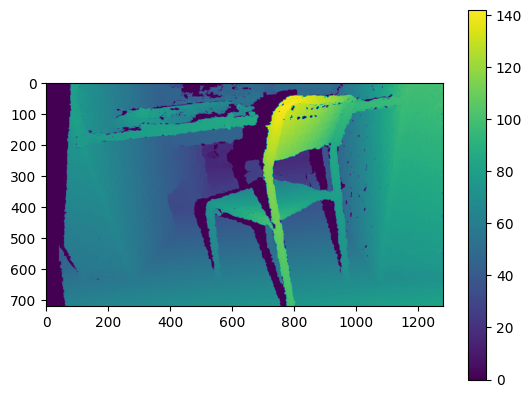

In [91]:
figure_show(full_agg)

In [92]:
xs = torch.tensor(trans_agg_restore, dtype=torch.float32).unsqueeze(0).clone().detach().requires_grad_(True)
xt = torch.tensor(scaled_agg, dtype=torch.float32).unsqueeze(0)
xd = torch.tensor(scaled_dl, dtype=torch.float32).unsqueeze(0)


In [93]:
KLOptim = KLTripletOptimizer(xs, xt, xd)
KLOptim.weights_adjust(20000, 1)

Running on: cuda


In [94]:
KLOptim.train(2500)

100%|██████████| 2500/2500 [00:08<00:00, 284.05it/s]


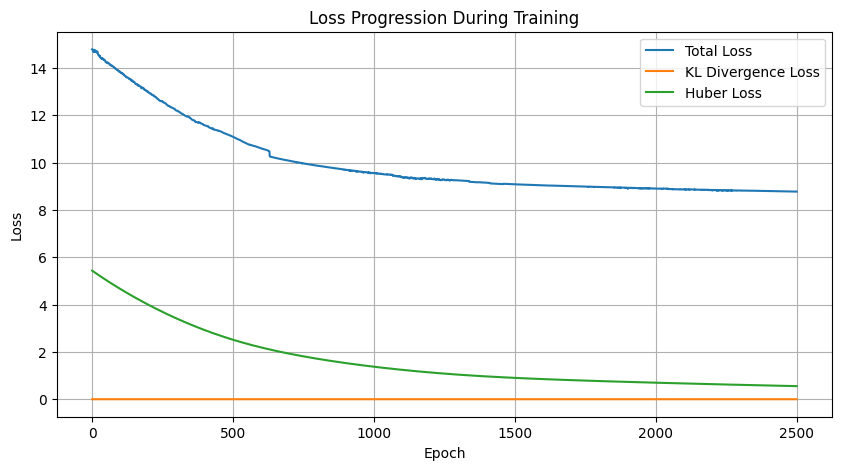

In [95]:
plt.figure(figsize=(10, 5))
plt.plot(KLOptim.total_losses, label='Total Loss')
plt.plot(KLOptim.kl_losses, label='KL Divergence Loss')
plt.plot(KLOptim.huber_losses, label='Huber Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Progression During Training')
plt.legend()
plt.grid(True)
plt.show()

In [96]:
o_trans_agg = KLOptim.xs.cpu().squeeze(0).detach().numpy()
print(o_trans_agg.shape)

(360, 640)


In [97]:
o_trans_agg

array([[  0.      ,   0.      ,   0.      , ..., 100.46285 , 100.539406,
        100.9385  ],
       [  0.      ,   0.      ,   0.      , ..., 100.239975, 100.087234,
        100.28773 ],
       [  0.      ,   0.      ,   0.      , ..., 100.04105 , 100.04164 ,
        100.265045],
       ...,
       [  0.      ,   0.      ,   0.      , ...,  82.01005 ,  82.01051 ,
         81.96385 ],
       [  0.      ,   0.      ,   0.      , ...,  82.011246,  82.01105 ,
         80.0913  ],
       [  0.      ,   0.      ,   0.      , ...,  82.01262 ,  82.00704 ,
         63.797142]], dtype=float32)

In [98]:
scaled_agg

array([[  0.        ,   0.        ,   0.        , ..., 100.42274504,
        100.49986807, 100.91964125],
       [  0.        ,   0.        ,   0.        , ..., 100.1994897 ,
        100.04780228, 100.24728491],
       [  0.        ,   0.        ,   0.        , ..., 100.00005891,
        100.00008003, 100.22326241],
       ...,
       [  0.        ,   0.        ,   0.        , ...,  82.        ,
         81.9999859 ,  81.95229186],
       [  0.        ,   0.        ,   0.        , ...,  82.        ,
         81.99942978,  80.07014717],
       [  0.        ,   0.        ,   0.        , ...,  82.        ,
         81.99459219,  63.69788986]])

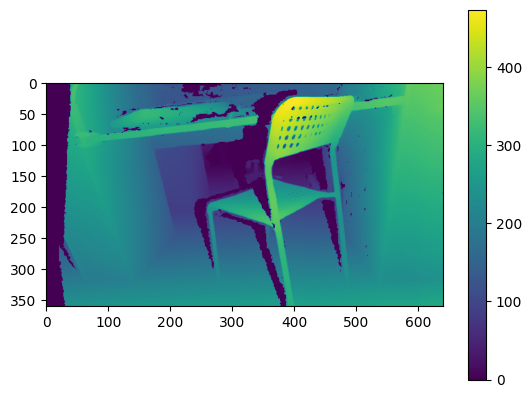

In [99]:
figure_show(dl)

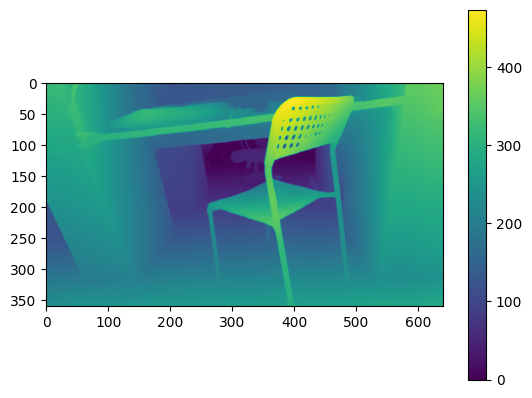

In [100]:
figure_show(scaled_dl)

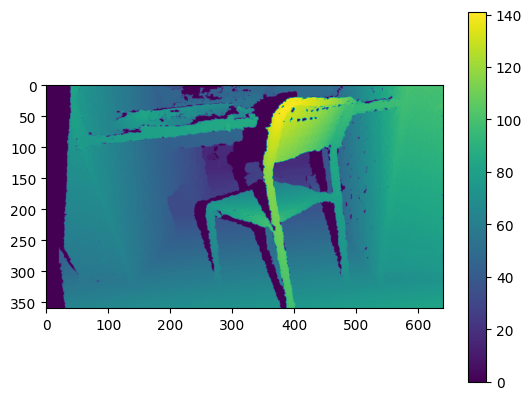

In [101]:
figure_show(scaled_agg)

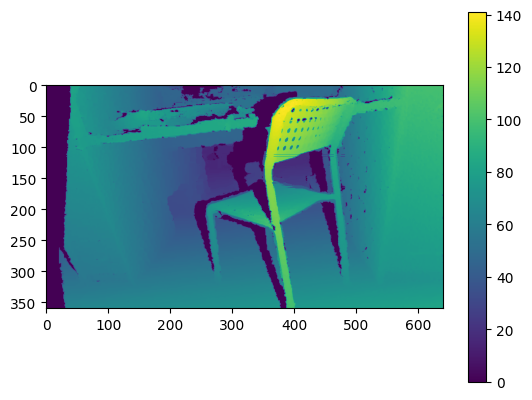

In [102]:
figure_show(o_trans_agg)

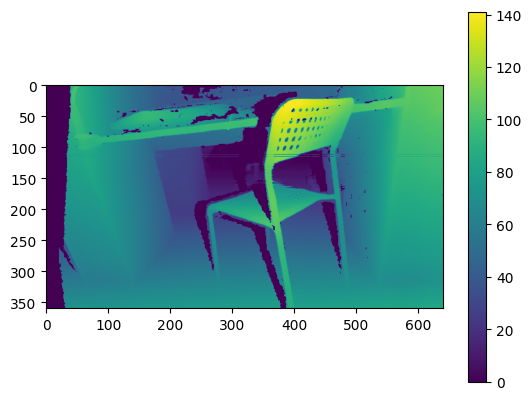

In [103]:
figure_show(trans_agg_restore)

In [104]:
trans_agg_restore

array([[  0.        ,   0.        ,   0.        , ..., 109.13954947,
        109.09256132, 105.01601385],
       [  0.        ,   0.        ,   0.        , ..., 108.99819843,
        108.6176457 , 109.03803456],
       [  0.        ,   0.        ,   0.        , ..., 108.90907979,
        109.03396691, 109.30589474],
       ...,
       [  0.        ,   0.        ,   0.        , ...,  84.18069937,
         84.28548353,  84.4615273 ],
       [  0.        ,   0.        ,   0.        , ...,  84.4413403 ,
         84.52160086,  84.66546477],
       [  0.        ,   0.        ,   0.        , ...,  84.7389431 ,
         84.69723282,  84.8507196 ]])

In [105]:
o_trans_agg

array([[  0.      ,   0.      ,   0.      , ..., 100.46285 , 100.539406,
        100.9385  ],
       [  0.      ,   0.      ,   0.      , ..., 100.239975, 100.087234,
        100.28773 ],
       [  0.      ,   0.      ,   0.      , ..., 100.04105 , 100.04164 ,
        100.265045],
       ...,
       [  0.      ,   0.      ,   0.      , ...,  82.01005 ,  82.01051 ,
         81.96385 ],
       [  0.      ,   0.      ,   0.      , ...,  82.011246,  82.01105 ,
         80.0913  ],
       [  0.      ,   0.      ,   0.      , ...,  82.01262 ,  82.00704 ,
         63.797142]], dtype=float32)

In [106]:
scaled_agg

array([[  0.        ,   0.        ,   0.        , ..., 100.42274504,
        100.49986807, 100.91964125],
       [  0.        ,   0.        ,   0.        , ..., 100.1994897 ,
        100.04780228, 100.24728491],
       [  0.        ,   0.        ,   0.        , ..., 100.00005891,
        100.00008003, 100.22326241],
       ...,
       [  0.        ,   0.        ,   0.        , ...,  82.        ,
         81.9999859 ,  81.95229186],
       [  0.        ,   0.        ,   0.        , ...,  82.        ,
         81.99942978,  80.07014717],
       [  0.        ,   0.        ,   0.        , ...,  82.        ,
         81.99459219,  63.69788986]])

In [107]:
mu_diff1 = (o_trans_agg-scaled_agg).mean()
mu_diff1

-0.29123146314794873

In [87]:
mu_diff2 = (trans_agg_restore-scaled_agg).mean()
mu_diff2

0.14386885609554267

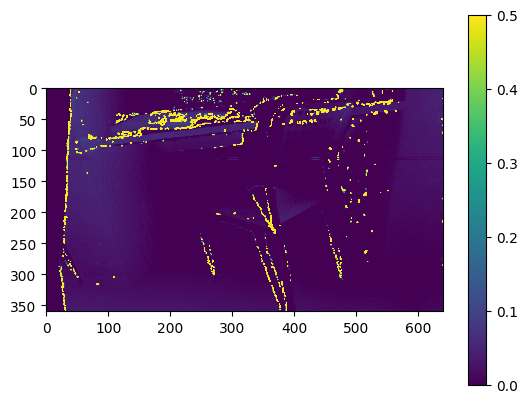

In [88]:
figure_show(o_trans_agg-scaled_agg, 0, 0, 0.5)

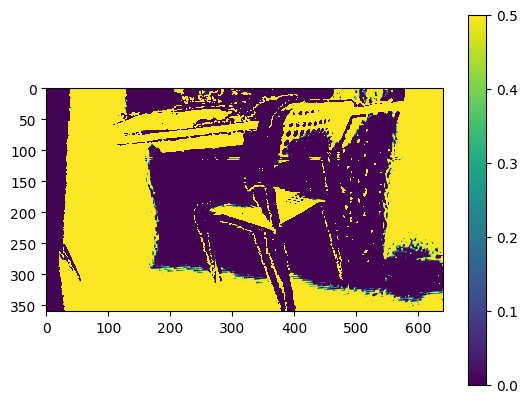

In [89]:
figure_show(trans_agg_restore-scaled_agg, 0, 0, 0.5)

This is for the feynman experiments

In [22]:
import os
import numpy as np

RAW_DISP = "disp.bin"
POST_DISP = "disp_postprocess.bin"
SAM_V2_VITL = "dam_v2_vitl_out.npy"
SAM_V2_VITB = "dam_v2_vitb_out.npy"
SAM_V2_VITS = "dam_v2_vits_out.npy"

In [23]:
def load_bin(path, h, w):
    return np.fromfile(path, dtype=np.uint16, count=h*w).reshape((h, w))

for folder 1

In [24]:
top_dir = "/home/william/extdisk/data/disp-refine/feynman/1/"
raw_disp = load_bin(os.path.join(top_dir, RAW_DISP), 480, 640) / 64
post_disp = load_bin(os.path.join(top_dir, POST_DISP), 480, 640) / 64
vitl_disp = np.load(os.path.join(top_dir, SAM_V2_VITL))
vitb_disp = np.load(os.path.join(top_dir, SAM_V2_VITB))
vits_disp = np.load(os.path.join(top_dir, SAM_V2_VITS))

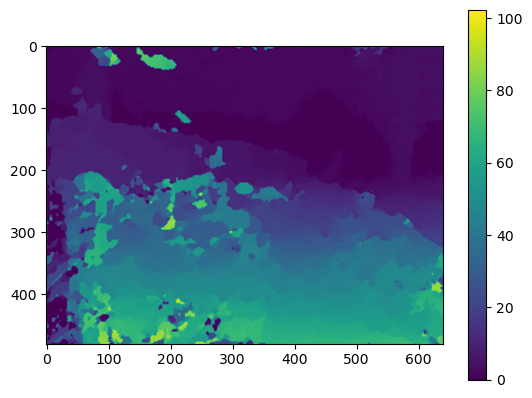

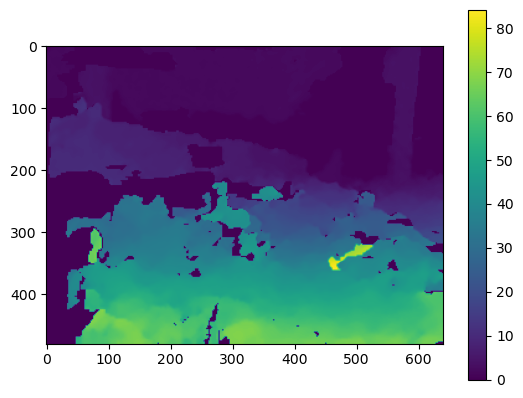

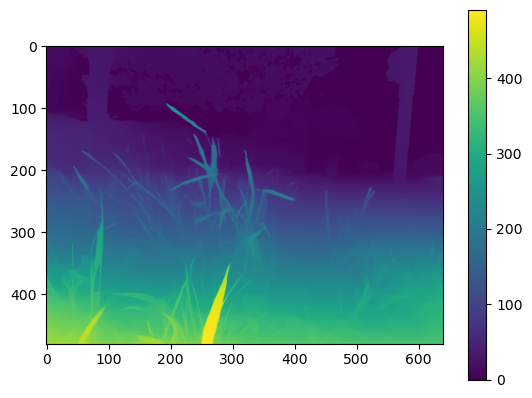

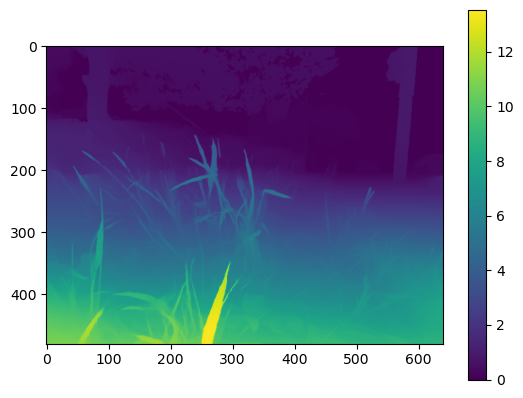

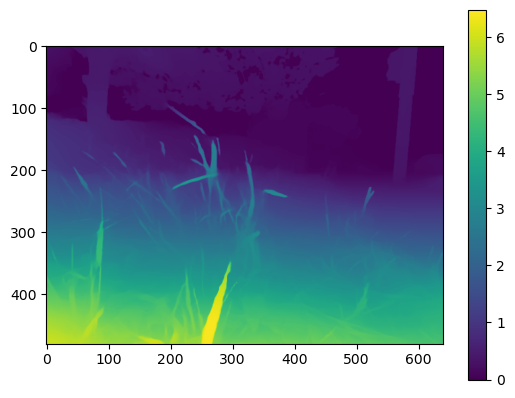

In [25]:
figure_show(raw_disp)
figure_show(post_disp)
figure_show(vitl_disp)
figure_show(vitb_disp)
figure_show(vits_disp)

In [28]:
insufficient_indices = np.where(raw_disp == 0)
dl = np.copy(vitl_disp)
dl[insufficient_indices] = 0


norm_raw, minv_raw, maxv_raw = minmax_normalizer(raw_disp)
norm_vitl, minv_vitl, maxv_vitl = minmax_normalizer(dl)
optimal_t = ot_transport_emd(norm_raw, norm_vitl)
optimal_t_r = restore_from_minmax(optimal_t, minv_raw, maxv_raw)

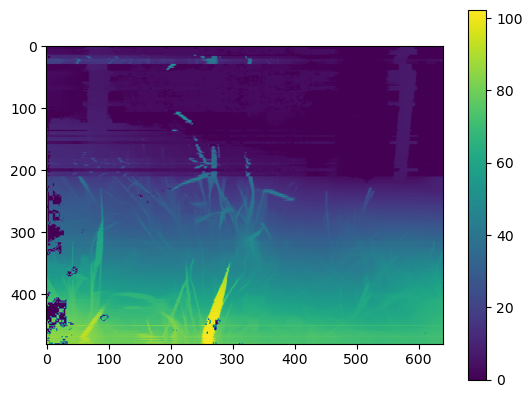

In [29]:
figure_show(optimal_t_r)

In [30]:
xs = torch.tensor(optimal_t_r, dtype=torch.float32).unsqueeze(0).clone().detach().requires_grad_(True)
xt = torch.tensor(raw_disp, dtype=torch.float32).unsqueeze(0)
xd = torch.tensor(dl, dtype=torch.float32).unsqueeze(0)

In [32]:
KLOptim = KLTripletOptimizer(xs, xt, xd)
KLOptim.weights_adjust(200000, 1)

Running on: cuda


In [33]:
KLOptim.train(1500)

100%|██████████| 1500/1500 [00:08<00:00, 174.76it/s]


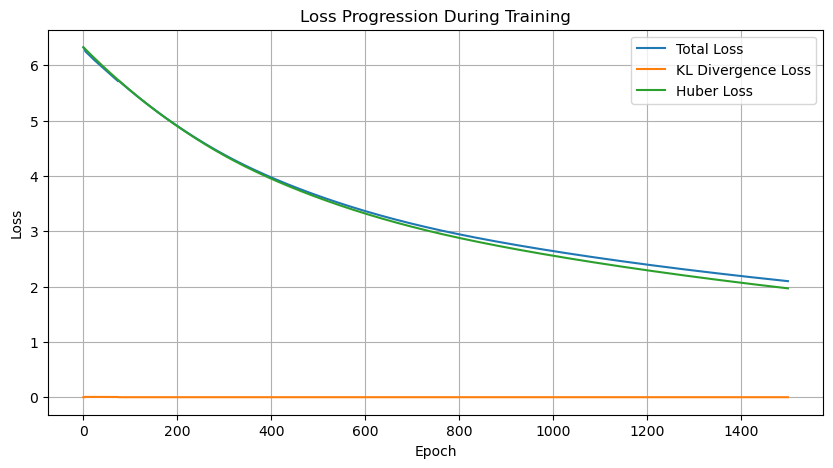

In [34]:
plt.figure(figsize=(10, 5))
plt.plot(KLOptim.total_losses, label='Total Loss')
plt.plot(KLOptim.kl_losses, label='KL Divergence Loss')
plt.plot(KLOptim.huber_losses, label='Huber Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Progression During Training')
plt.legend()
plt.grid(True)
plt.show()

In [35]:
o_t = KLOptim.xs.cpu().squeeze(0).detach().numpy()
print(o_t.shape)

(480, 640)


In [36]:
o_t[o_t < 1] = 0
o_t

array([[ 0.       ,  0.       ,  0.       , ...,  3.602838 ,  3.602838 ,
         3.602838 ],
       [ 0.       ,  0.       ,  0.       , ...,  3.696015 ,  3.696015 ,
         3.696015 ],
       [ 0.       ,  0.       ,  0.       , ...,  3.9134276,  3.9134276,
         3.9134276],
       ...,
       [72.15661  , 71.993454 , 72.00054  , ..., 76.11623  , 76.11694  ,
        76.10149  ],
       [68.188736 , 68.06809  , 68.01888  , ..., 76.078445 , 76.079315 ,
        76.080025 ],
       [72.73612  , 72.592926 , 72.55414  , ..., 76.10422  , 76.10565  ,
        76.1046   ]], dtype=float32)

In [37]:
raw_disp

array([[ 0.      ,  0.      ,  0.      , ...,  3.625   ,  3.625   ,
         3.625   ],
       [ 0.      ,  0.      ,  0.      , ...,  3.71875 ,  3.71875 ,
         3.71875 ],
       [ 0.      ,  0.      ,  0.      , ...,  3.9375  ,  3.9375  ,
         3.9375  ],
       ...,
       [17.984375, 18.078125, 18.234375, ..., 76.140625, 76.140625,
        76.125   ],
       [18.      , 18.046875, 18.171875, ..., 76.125   , 76.125   ,
        76.125   ],
       [18.      , 18.046875, 18.125   , ..., 76.125   , 76.125   ,
        76.125   ]])

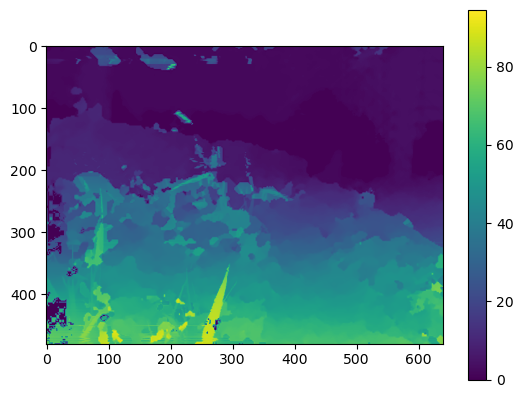

In [38]:
figure_show(o_t)

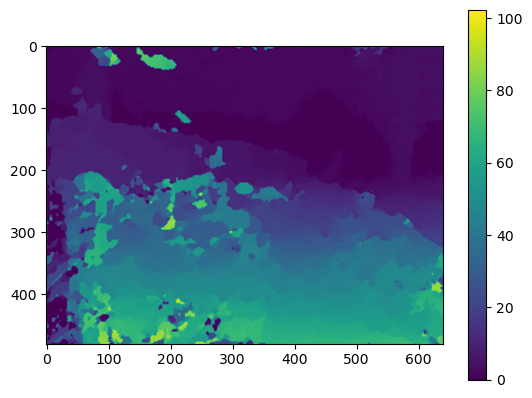

In [39]:
figure_show(raw_disp)

In [40]:
print(np.mean(raw_disp-o_t))

-0.6683537478143504


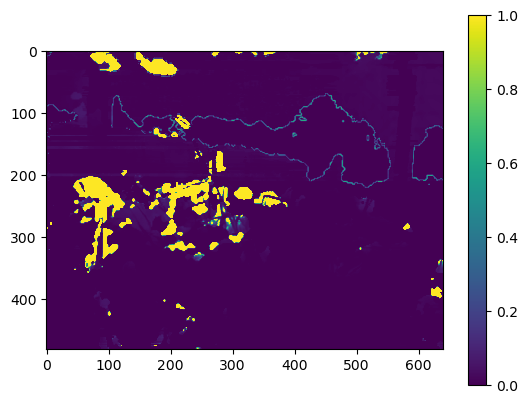

In [42]:
figure_show(raw_disp-o_t, 0, 0, 1)